In [1]:
from scipy.stats import invgamma
from scipy.stats import norm
from multiprocessing import Pool
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def integral(estimate, ts):
    elements = np.ones(len(ts) - 1)
    for i in range(len(ts) - 1):
        elements[i] = (ts[i+1] - ts[i])*(estimate[i+1] + estimate[i])/2
    return sum(elements)

def sum1(beta):
    return np.sum(p[:, 0] - beta * p[:, 3])

def sum2(alpha):
    return np.sum(p[:, 3] * (p[:, 0] - alpha))

def sum3(alpha, beta):
    l = (p[:, 0] - alpha - beta*p[:, 3])
    return np.sum(l * l )

def loglike(alpha, beta, sigma):
    return N*np.log(1/(np.sqrt(2*np.pi*sigma))) - sum3(alpha, beta) / (2*sigma)

def function1(w):
    if w < m:
        np.random.seed(datetime.now().microsecond)
        estimates = np.ones(n+1)

        for i in range(n+1):
            t = ts[i]

            alphas = np.ones(sample_iter)
            betas = np.ones(sample_iter)
            sigmas = np.ones(sample_iter)
            
            if i == 0:
                alphas[0] = 3000
                betas[0] = 185
                sigmas[0] = 90000

            else:
                alphas[0] = np.mean(alpha_sample)
                betas[0] = np.mean(beta_sample)
                sigmas[0] = np.mean(sigma_sample)

            for j in range(sample_iter -1):

                location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
                scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
                alphas[j+1] = norm.rvs(loc = location_alpha, scale = scale_alpha)

                location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta *t* var*N + sigmas[-1])
                scale_beta = np.sqrt((sigmas[-1] * sigma_beta) / (sigma_beta *t* var*N + sigmas[-1]))
                betas[j+1] = norm.rvs(loc = location_beta, scale = scale_beta)

                shape = N*t/2 + a
                invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
                sigmas[j+1] = invgamma.rvs(a = shape, scale = 1/ invrate)

            alpha_sample = alphas[burn_in:]
            beta_sample = betas[burn_in:len(betas)]
            sigma_sample = sigmas[burn_in:len(sigmas)]

            box = np.ones(len(alpha_sample))
            for k, l in enumerate(alpha_sample):
                box[k] = loglike(l, beta_sample[k], sigma_sample[k])

            estimates[i] = np.average(box)
        
        return estimates
    
def sum4(beta):
    return np.sum(p[:, 0] - beta * p[:, 4])

def sum5(alpha):
    return np.sum(p[:, 4] * (p[:, 0] - alpha))

def sum6(alpha, beta):
    l = (p[:, 0] - alpha - beta*p[:, 4])
    return np.sum(l * l )  

def loglike2(alpha, beta, sigma):
    return N*np.log(1/(np.sqrt(2*np.pi*sigma))) - sum6(alpha, beta) / (2*sigma)
    
def function2(w):
    if w < m:
        np.random.seed(datetime.now().microsecond)
        estimates = np.ones(n+1)

        for i in range(n+1):
            t = ts[i]

            gammas = np.ones(sample_iter)
            deltas = np.ones(sample_iter)
            taus = np.ones(sample_iter)
            
            if i == 0:
                gammas[0] = 3000
                deltas[0] = 185
                taus[0] = 90000

            else:
                gammas[0] = np.mean(gamma_sample)
                deltas[0] = np.mean(delta_sample)
                taus[0] = np.mean(tau_sample)

            for j in range(sample_iter - 1):

                location_alpha = (sigma_alpha*t*sum4(deltas[-1]) + taus[-1]*mu_alpha) / (sigma_alpha * N*t + taus[-1])
                scale_alpha = np.sqrt((sigma_alpha * taus[-1]) / (sigma_alpha * N*t + taus[-1]))
                gammas[j+1] = norm.rvs(loc = location_alpha, scale = scale_alpha)

                location_beta = (sigma_beta * t * sum5(gammas[-1]) + taus[-1] * mu_beta) / (sigma_beta *t* var2*N + taus[-1])
                scale_beta = np.sqrt((taus[-1] * sigma_beta) / (sigma_beta *t* var2*N + taus[-1]))
                deltas[j+1] = norm.rvs(loc = location_beta, scale = scale_beta)

                shape = N*t/2 + a
                invrate = 2*b / (b*t*sum6(gammas[-1], deltas[-1]) + 2)
                taus[j+1] = invgamma.rvs(a = shape, scale = 1/ invrate)

            gamma_sample = gammas[burn_in:]
            delta_sample = deltas[burn_in:len(deltas)]
            tau_sample = taus[burn_in:len(taus)]

            box2 = np.ones(len(gamma_sample))
            for k, l in enumerate(gamma_sample):
                box2[k] = loglike2(l, delta_sample[k], tau_sample[k])

            estimates[i] = np.average(box2)
        
        return estimates

In [4]:
pine = pd.read_table("pine.txt", delim_whitespace = True)
p = pine.values
pine['ave_x'] = pine['x'] - np.average(p[:, 1])
pine['ave_z'] = pine['z'] - np.average(p[:, 2])
p = pine.values

mu_alpha = 3000
sigma_alpha = 10**6
mu_beta = 185
sigma_beta = 10**4
a = 3
b = 1/(2*300**2)

N = np.shape(p)[0]
var = np.var(p[:, 1])
var2 = np.var(p[:, 2])

n = 10
c = 2
ts = [(i/n)**c for i in range(n+1)]

# ここをいじってね。
sample_iter = 10000
burn_in = 30
m = 10
core = 2


収束の確認

In [5]:
# model 1

n = 10
c = 2
######

estimates = np.ones(n+1)
ts = np.ones(n+1)


t = (1/n)**c


alphas = np.ones(sample_iter)
betas = np.ones(sample_iter)
sigmas = np.ones(sample_iter)


alphas[0] = 3000
betas[0] = 185
sigmas[0] = 90000


for j in range(sample_iter -1):

    location_alpha = (sigma_alpha*t*sum1(betas[-1]) + sigmas[-1]*mu_alpha) / (sigma_alpha * N*t + sigmas[-1])
    scale_alpha = np.sqrt((sigma_alpha * sigmas[-1]) / (sigma_alpha * N*t + sigmas[-1]))
    r = norm.rvs(loc = location_alpha, scale = scale_alpha)
    alphas[j+1] = r

    location_beta = (sigma_beta * t * sum2(alphas[-1]) + sigmas[-1] * mu_beta) / (sigma_beta *t* var*N + sigmas[-1])
    scale_beta = np.sqrt((sigmas[-1] * sigma_beta) / (sigma_beta *t* var*N + sigmas[-1]))
    q = norm.rvs(loc = location_beta, scale = scale_beta)
    betas[j+1] = q

    shape = N*t/2 + a
    invrate = 2*b / (b*t*sum3(alphas[-1], betas[-1]) + 2)
    s = invgamma.rvs(a = shape, scale = 1/ invrate)
    sigmas[j+1] = s

<function matplotlib.pyplot.plot>

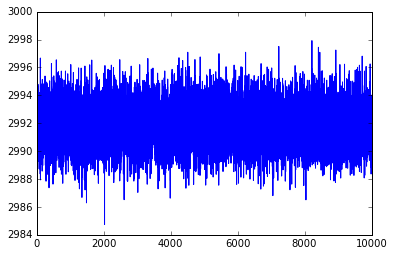

In [6]:
plt.plot(alphas)
plt.plot

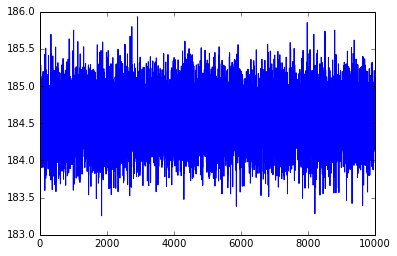

In [7]:
plt.plot(betas)

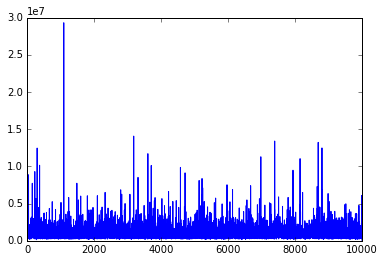

In [8]:
plt.plot( sigmas)

In [9]:
# model 2

n = 10
c = 2
######

estimates = np.ones(n+1)
ts = np.ones(n+1)


t = (1/n)**c


gammas = np.ones(sample_iter)
deltas = np.ones(sample_iter)
taus = np.ones(sample_iter)


gammas[0] = 3000
deltas[0] = 185
taus[0] = 90000

for j in range(sample_iter - 1):

    location_alpha = (sigma_alpha*t*sum4(deltas[-1]) + taus[-1]*mu_alpha) / (sigma_alpha * N*t + taus[-1])
    scale_alpha = np.sqrt((sigma_alpha * taus[-1]) / (sigma_alpha * N*t + taus[-1]))
    r = norm.rvs(loc = location_alpha, scale = scale_alpha)
    gammas[j+1] = r

    location_beta = (sigma_beta * t * sum5(gammas[-1]) + taus[-1] * mu_beta) / (sigma_beta *t* var2*N + taus[-1])
    scale_beta = np.sqrt((taus[-1] * sigma_beta) / (sigma_beta *t* var2*N + taus[-1]))
    q = norm.rvs(loc = location_beta, scale = scale_beta)
    deltas[j+1] = q

    shape = N*t/2 + a
    invrate = 2*b / (b*t*sum6(gammas[-1], deltas[-1]) + 2)
    s = invgamma.rvs(a = shape, scale = 1/ invrate)
    taus[j+1] = s

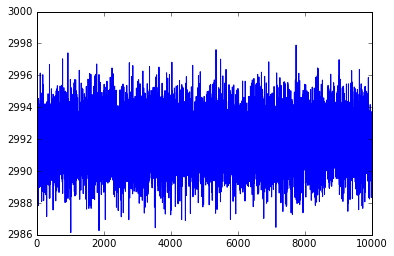

In [10]:
plt.plot(gammas)

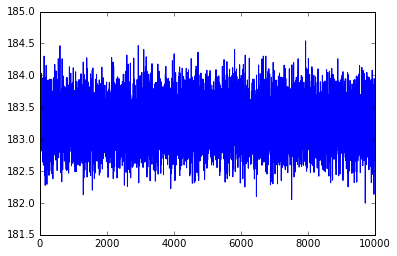

In [11]:
plt.plot(deltas)

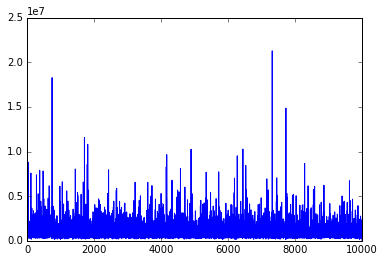

In [12]:
plt.plot(taus)

# computing BF


model1

In [8]:
if __name__ == '__main__':
    w = Pool(core) 
    result1 = w.map(function1, range(m))

In [9]:
result1

[array([-728.55969781, -328.01082018, -349.01965143, -359.33315849,
        -365.56834255, -368.6877269 , -371.07397053, -372.42973348,
        -373.01016695, -373.82815944, -374.2664817 ]),
 array([-727.90827564, -327.92018   , -349.22389888, -359.59129333,
        -365.50118641, -368.49064462, -370.87974274, -371.98426289,
        -373.39306002, -373.84011626, -374.45631278]),
 array([-733.51473285, -328.22240633, -349.2321366 , -359.17614438,
        -365.11757819, -368.38045111, -370.79435549, -372.19027629,
        -373.26484552, -373.8554604 , -374.19285951]),
 array([-726.59573511, -328.09398039, -349.37163629, -359.591179  ,
        -365.35470365, -369.00008553, -370.80020733, -372.42122933,
        -372.72641372, -373.95361654, -374.46436901]),
 array([-735.4437363 , -327.77145304, -348.39639937, -359.22255366,
        -365.31976431, -368.16383161, -370.68416976, -371.85739772,
        -372.98844276, -373.86562695, -374.30914695]),
 array([-722.27141085, -327.67450801, -349.12

In [10]:
expect1 = np.ones(10)
for i in range(10):
    expect1[i] = integral(result1[i], ts)

In [11]:
expect1

array([-371.03308088, -371.02236408, -370.96596843, -371.03056853,
       -370.83928995, -370.91224734, -370.93798767, -370.90713072,
       -371.04823566, -371.12504469])

model2

In [12]:
if __name__ == '__main__':
    result2 = w.map(function2, range(m))

In [13]:
expect2 = np.ones(10)
for i in range(10):
    expect2[i] = integral(result2[i], ts)

In [14]:
expect2

array([-370.69481978, -370.86417251, -370.85323004, -370.9056726 ,
       -370.78395936, -370.61170256, -370.50821695, -370.83175627,
       -370.80582537, -370.6920544 ])

BF21

In [15]:
bf_21 = []
for a,b in zip(expect1, expect2):
    bf_21.append(np.exp(b-a))

In [16]:
bf_21

[1.4025066371469483,
 1.1713905770074899,
 1.1193390673644366,
 1.1330305413923905,
 1.0568899543878427,
 1.3505943842452597,
 1.5369051003187191,
 1.0782878439593513,
 1.2743169267459826,
 1.5418612476711611]